In [4]:

from mnist import load_mnist
import numpy as np
import matplotlib.pyplot as plt
from typing_extensions import Counter
from sklearn.model_selection import  train_test_split
from sklearn.metrics import accuracy_score
train, validation, test = load_mnist()

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [5]:
# Создаем класс для метода PCA (Principal Component Analysis)
# PCA помогает уменьшить количество измерений в данных, сохраняя самую важную информацию
class my_PCA():
    def __init__(self, n_components=None):
        pass  # Пока ничего не делаем при создании объекта

    def fit(self, X):
        # Вычисляем среднее значение для каждого пикселя по всем изображениям
        self.X_mean = X.mean(axis=0)

        # Центрируем данные: вычитаем среднее значение из каждого пикселя
        X_centred = X - self.X_mean

        # Создаем ковариационную матрицу - показывает, как пиксели связаны друг с другом
        C_matrix = X_centred.T @ X_centred

        # Находим собственные значения и собственные векторы матрицы
        # Это как бы "направления" самой важной информации в данных
        lamb, F = np.linalg.eig(C_matrix)

        # Сортируем собственные значения по убыванию (самые важные сначала)
        idx = np.argsort(lamb)[::-1]
        self.lamb_sorted = lamb[idx]
        F_sorted = F[:, idx]

        # Берем только 64 самых важных направления (компоненты)
        self.vt = F_sorted[:, :64]

    def transform(self, X):
        # Центрируем новые данные
        X_centred = X - self.X_mean

        # Проецируем данные на новые направления (уменьшаем размерность)
        Y = X_centred @ self.vt
        print(f"Новый размер данных: {Y.shape}")
        return Y

    def fit_transform(self, X):
        # Объединяем два шага: обучение и преобразование
        self.fit(X)
        return self.transform(X)



In [6]:
# Создаем класс для метода k-ближайших соседей (kNN)
# Этот метод классифицирует объекты по тому, на какие похожи объекты из обучающей выборки
class my_kNN():
    def __init__(self, n_neighbors=30):
        self.n_neighbors = n_neighbors  # Сколько соседей рассматривать

    def fit(self, X, y):
        # Запоминаем обучающие данные и соответствующие им метки (цифры)
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_predict = []  # Сюда будем складывать предсказания

        # Для каждого нового изображения
        for x in X:
            # Вычисляем расстояние до всех обучающих изображений
            distance = np.linalg.norm(self.X_train - x, axis=1)

            # Находим индексы k ближайших соседей
            k_nearest = np.argsort(distance)[:self.n_neighbors]

            # Смотрим, какие цифры у этих соседей
            types = self.y_train[k_nearest]

            # Берем самую частую цифру среди соседей
            m = Counter(types).most_common(1)[0][0]
            y_predict.append(m)

        return np.array(y_predict)

In [7]:
# Получаем обучающие данные: 55000 изображений размером 28x28 пикселей
X = train[0]  # Изображения
X = X.reshape(55000, -1)  # Преобразуем в плоский формат (784 пикселя на изображение)
labels = train[1]  # Метки (какая цифра на каждом изображении)


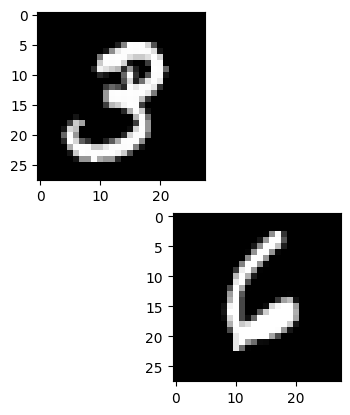

In [8]:
# Показываем примеры изображений
plt.subplot(2, 2, 4)
plt.imshow(X[3].reshape(28, 28), cmap="gray")  # Преобразуем обратно в 28x28 и показываем

plt.subplot(2, 1, 1)
plt.imshow(X[1].reshape(28, 28), cmap="gray")

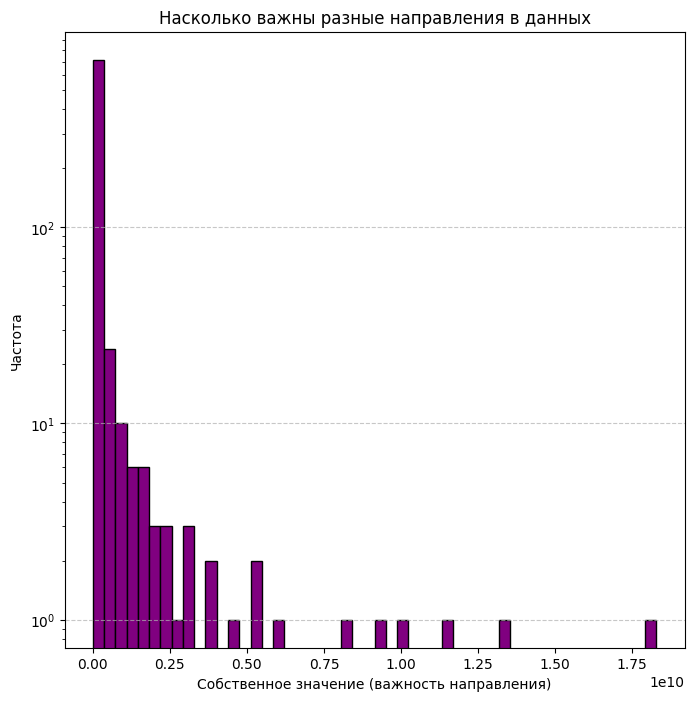

In [13]:
pca = my_PCA()
pca.fit(X)

# Рисуем гистограмму собственных значений - показываем важность каждого направления
plt.figure(figsize=(8, 8))
plt.hist(pca.lamb_sorted, bins=50, edgecolor='black', color='purple')
plt.yscale('log')  # Логарифмическая шкала для лучшей видимости
plt.xlabel("Собственное значение (важность направления)")
plt.ylabel("Частота")
plt.title("Насколько важны разные направления в данных")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


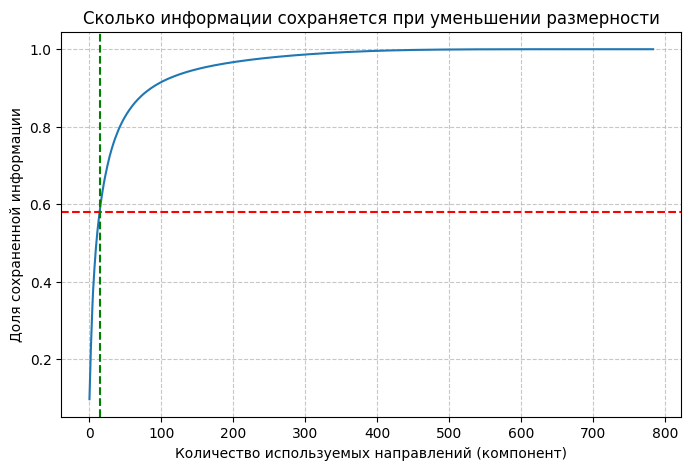

In [14]:
# Показываем, какая доля информации сохраняется при использовании разного числа компонент
pca = my_PCA()
pca.fit(X)
cumsum = np.cumsum(pca.lamb_sorted)  # Накопленная сумма важности
ratio = cumsum / cumsum[-1]  # Доля от общей важности

plt.figure(figsize=(8, 5))
plt.plot(ratio)
plt.axhline(y=ratio[14], color='r', linestyle='--')  # Горизонтальная линия на уровне 14 компонент
plt.axvline(x=14, color='g', linestyle='--')  # Вертикальная линия на 14 компонентах
plt.xlabel("Количество используемых направлений (компонент)")
plt.ylabel("Доля сохраненной информации")
plt.title("Сколько информации сохраняется при уменьшении размерности")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Новый размер данных: (55000, 64)


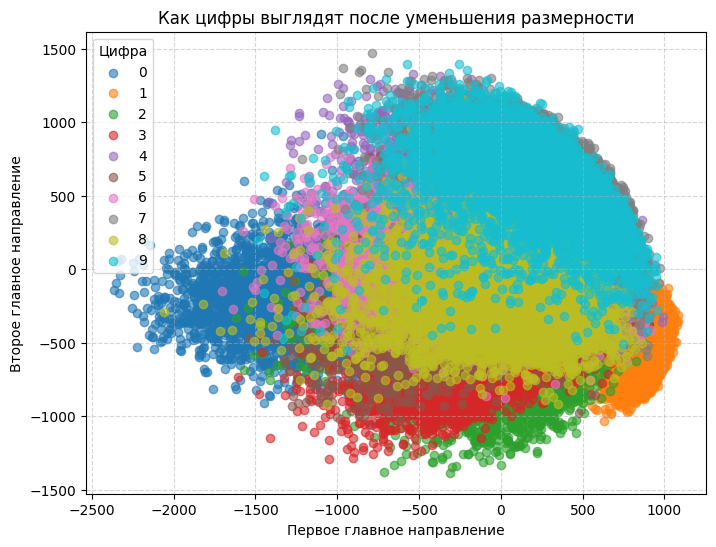

In [15]:
# Визуализируем данные в 2D после PCA
pca = my_PCA()
pca.fit(X)
X_pca = pca.transform(X)  # Преобразуем данные в новое пространство

# Рисуем scatter plot - каждую цифру своим цветом
classes = np.unique(labels)
plt.figure(figsize=(8,6))
for cls in classes:
    plt.scatter(X_pca[labels==cls, 0], X_pca[labels==cls, 1],
                label=str(cls), alpha=0.6)
plt.legend(title="Цифра")
plt.xlabel("Первое главное направление")
plt.ylabel("Второе главное направление")
plt.title("Как цифры выглядят после уменьшения размерности")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [22]:
# Разделяем данные на обучающую и тестовую части
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42, stratify=labels)  # Добавил stratify для балансировки классов

print(f"Размер обучающей выборки: {X_train.shape}, меток: {y_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}, меток: {y_test.shape}")

# Применяем PCA к обучающим данным
pca = my_PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
print(f"Новый размер обучающих данных: {X_train_pca.shape}")

# Применяем то же преобразование к тестовым данным
X_test_pca = pca.transform(X_test)
print(f"Новый размер тестовых данных: {X_test_pca.shape}")

# Создаем и обучаем классификатор kNN
knn = my_kNN(n_neighbors=3)  # Уменьшил до 3 соседей для скорости (можно попробовать 5 если точность важнее)

# УСКОРЕНИЕ: используем только часть данных для демонстрации
# Для полного обучения уберите эти строки
sample_size = 2000  # Берем только 2000 образцов для быстрой демонстрации
X_train_sample = X_train_pca[:sample_size]
y_train_sample = y_train[:sample_size]

knn.fit(X_train_sample, y_train_sample)  # Обучаем на уменьшенной выборке

# Для теста тоже берем только часть данных
test_sample_size = 1000
X_test_sample = X_test_pca[:test_sample_size]
y_test_sample = y_test[:test_sample_size]

# Делаем предсказания для тестовых данных
print("Делаем предсказания...")
y_pred = knn.predict(X_test_sample)
print(f"Первые несколько предсказаний: {y_pred[:10]}")
print(f"Реальные значения для сравнения: {y_test_sample[:10]}")

# Оцениваем точность предсказаний
accuracy = accuracy_score(y_test_sample, y_pred)
print(f"Точность предсказаний: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Покажем несколько примеров с предсказаниями
print("\nПримеры предсказаний:")
for i in range(min(5, len(y_test_sample))):  # Защита от выхода за границы
    print(f"Изображение {i+1}: Предсказано - {y_pred[i]}, Реально - {y_test_sample[i]}, {'✓' if y_pred[i] == y_test_sample[i] else '✗'}")

Размер обучающей выборки: (44000, 784), меток: (44000,)
Размер тестовой выборки: (11000, 784), меток: (11000,)
Новый размер данных: (44000, 64)
Новый размер обучающих данных: (44000, 64)
Новый размер данных: (11000, 64)
Новый размер тестовых данных: (11000, 64)
Делаем предсказания...
Первые несколько предсказаний: [1 9 9 7 0 5 0 9 6 2]
Реальные значения для сравнения: [1 9 9 7 0 5 0 4 6 2]
Точность предсказаний: 0.9210 (92.10%)

Примеры предсказаний:
Изображение 1: Предсказано - 1, Реально - 1, ✓
Изображение 2: Предсказано - 9, Реально - 9, ✓
Изображение 3: Предсказано - 9, Реально - 9, ✓
Изображение 4: Предсказано - 7, Реально - 7, ✓
Изображение 5: Предсказано - 0, Реально - 0, ✓
